# Cavern storage capacity

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import ticker

from h2ss import capacity as cap
from h2ss import data as rd
from h2ss import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

In [5]:
# exploration wells
_, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

# wind farms
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

# frequent shipping routes
_, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

# shipwrecks
_, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

# subsea cables
_, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

# distance from salt formation edge
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [6]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 85, "min_depth": 500, "max_depth": 2000}
)

## Generate caverns

In [7]:
caverns, _ = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

------------------------------------------------------------
Without constraints, excluding salt formation edges...
Number of potential caverns: 4,084
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 1,776
Caverns excluded: 56.51%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 1,416
Caverns excluded: 65.33%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 1,348
Caverns excluded: 66.99%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 1,348
Caverns excluded: 66.99%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 1,348
Caverns excluded: 66.99%
------------------------------------------------------------


In [8]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[85, 155, 311],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

## Capacity

### Volume

In [9]:
caverns["cavern_volume"] = cap.cavern_volume(height=caverns["cavern_height"])
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_volume"]
)

### Mid-point temperature

In [10]:
caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

### Operating pressure

In [11]:
(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepthSeabed"])

### Hydrogen gas density

In [12]:
caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

### Working mass of hydrogen

In [13]:
(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

### Energy storage capacity in GWh

In [14]:
caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

## Stats

In [15]:
# proportion of working gas to total gas
caverns["working_mass_pct"] = caverns["working_mass"] / (
    caverns["working_mass"] + caverns["mass_operating_min"]
)

In [18]:
caverns.drop(
    ["x", "y", "TopTWT", "BaseDepth", "TopDepth", "BaseDepthSeabed"], axis=1
).describe()

,Thickness,TopDepthSeabed,cavern_height,cavern_depth,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,mass_operating_min,mass_operating_max,capacity,working_mass_pct
count,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000,1348.000000,1.348000e+03,1.348000e+03,1348.000000,1348.000000,1.348000e+03,1.348000e+03,1.348000e+03,1348.000000,1348.000000
mean,291.406212,1050.457546,146.683976,1130.457546,306430.665120,328.292483,7.743322e+06,2.064886e+07,5.390096,13.354116,2.474540e+06,1.677202e+06,4.151741e+06,82.457158,0.598618
std,82.368687,382.540338,63.614451,382.540338,153163.171539,14.529735,2.701959e+06,7.205224e+06,1.583208,3.664337,1.510169e+06,1.057325e+06,2.566757e+06,50.322180,0.008196
min,175.062400,420.214316,85.000000,500.214316,157915.456354,303.573246,3.291788e+06,8.778101e+06,2.569076,6.638388,6.475588e+05,4.089690e+05,1.056528e+06,21.578099,0.581422
25%,227.066775,725.721477,85.000000,805.721477,157915.456354,316.015351,5.449646e+06,1.453239e+07,4.051643,10.272413,1.407565e+06,9.212624e+05,2.326087e+06,46.903202,0.592482
50%,272.752950,1012.201219,155.000000,1092.201219,326452.980096,326.997101,7.473110e+06,1.992829e+07,5.316731,13.261473,2.127271e+06,1.391791e+06,3.519062e+06,70.885388,0.599073
75%,341.484950,1323.807191,155.000000,1403.807191,326452.980096,338.612438,9.674045e+06,2.579745e+07,6.576871,16.138849,3.031079e+06,2.073404e+06,5.105912e+06,101.002287,0.605580
max,754.985800,1919.031682,311.000000,1999.031682,702050.890150,361.559570,1.387823e+07,3.700863e+07,8.689494,20.759546,8.253605e+06,5.907769e+06,1.416137e+07,275.028458,0.612997


In [16]:
# cavern volumes
list(caverns["cavern_volume"].unique())

[702050.8901495441, 326452.98009604175, 157915.45635408553]

In [17]:
# totals
caverns[
    [
        "cavern_volume",
        "working_mass",
        "capacity",
        "mass_operating_min",
        "mass_operating_max",
    ]
].sum()

cavern_volume         4.130685e+08
working_mass          3.335679e+09
capacity              1.111522e+05
mass_operating_min    2.260868e+09
mass_operating_max    5.596547e+09
dtype: float64

In [19]:
# compare to Ireland's electricity demand in 2050 (Deane, 2021)
print(
    "Energy capacity as a percentage of Ireland's electricity demand in 2050:",
    f"{(caverns['capacity'].sum() / 1000 / 122 * 100):.2f}–" +
    f"{(caverns['capacity'].sum() / 1000 / 84 * 100):.2f}%"
)

Energy capacity as a percentage of Ireland's electricity demand in 2050: 91.11–132.32%


In [63]:
# total capacity at various depth/height combinations
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

capacity          %
height depth                                 
311    1,000 - 1,500  15316.891369  13.780100
155    1,000 - 1,500  33585.265583  30.215552
85     1,000 - 1,500   8111.737874   7.297862
311    500 - 1,000     3879.145235   3.489939
       1,500 - 2,000   8064.693292   7.255538
155    500 - 1,000    17464.937277  15.712626
       1,500 - 2,000  13900.827300  12.506114
85     1,500 - 2,000   4191.742196   3.771172
       500 - 1,000     6637.008568   5.971097

In [64]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",57013.894825
"1,500 - 2,000",26157.262787
"500 - 1,000",27981.091080


In [65]:
s.groupby("height").sum()[["capacity"]]

,capacity
height,
155,64951.030159
311,27260.729895
85,18940.488638


In [66]:
# number of caverns
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].count()
s["%"] = s["capacity"] / len(caverns) * 100
s

capacity          %
height depth                             
311    1,000 - 1,500        75   5.563798
155    1,000 - 1,500       357  26.483680
85     1,000 - 1,500       175  12.982196
311    500 - 1,000          28   2.077151
       1,500 - 2,000        32   2.373887
155    500 - 1,000         281  20.845697
       1,500 - 2,000       114   8.456973
85     1,500 - 2,000        72   5.341246
       500 - 1,000         214  15.875371

In [67]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",607
"1,500 - 2,000",218
"500 - 1,000",523


In [68]:
s.groupby("height").sum()[["capacity"]]

,capacity
height,
155,752
311,135
85,461


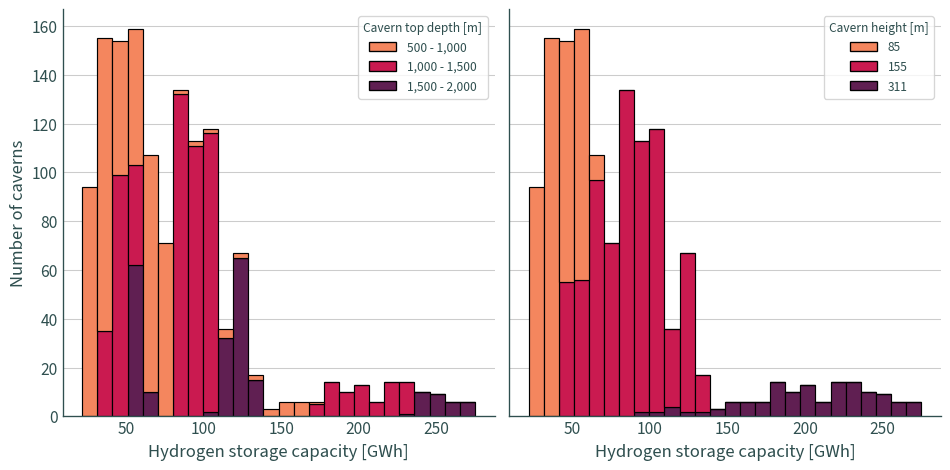

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.histplot(
    caverns.rename(columns={"depth": "Cavern top depth [m]"}).sort_values(
        "TopDepthSeabed"
    ),
    x="capacity",
    hue="Cavern top depth [m]",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
    ax=axes[0],
)
sns.histplot(
    caverns.rename(columns={"height": "Cavern height [m]"}).sort_values(
        "Thickness"
    ),
    x="capacity",
    hue="Cavern height [m]",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
    ax=axes[1],
)
axes[0].set_xlabel("Hydrogen storage capacity [GWh]")
axes[1].set_xlabel("Hydrogen storage capacity [GWh]")
axes[0].grid(which="major", axis="y")
axes[1].grid(which="major", axis="y")
axes[0].set_ylabel("Number of caverns")
sns.despine()
plt.tight_layout()
plt.show()

In [20]:
# copy dataframe
caverns_pot_all = caverns.copy()

## Maps

In [21]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [22]:
def plot_map_alt(
    dat_xr, cavern_df, zones_gdf, classes, top_depth=True, fontsize=11.5
):
    """Helper function to plot caverns within the zones of interest"""
    plt.figure(figsize=(20, 11.5))
    axis1 = plt.axes(projection=ccrs.epsg(rd.CRS))
    legend_handles1 = []
    classes = sorted(classes)

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis1,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis1, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis1,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Area of interest",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis1,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    legend_handles1.append(
        mpatches.Patch(
            label="Hydrogen storage \ncapacity [GWh]", visible=False
        )
    )

    colours = [int(n * 255 / (len(classes) - 1)) for n in range(len(classes))]
    for n, y in enumerate(colours):
        if n == 0:
            c = cavern_df[cavern_df["capacity"] < classes[1]]
            label1 = f"< {classes[1]}"
        elif n == len(classes) - 1:
            c = cavern_df[cavern_df["capacity"] >= classes[n]]
            label1 = f"≥ {classes[n]}"
        else:
            c = cavern_df[
                (cavern_df["capacity"] >= classes[n])
                & (cavern_df["capacity"] < classes[n + 1])
            ]
            label1 = f"{classes[n]}–{classes[n + 1]}"
        if top_depth:
            for df, markersize in zip(
                [
                    c[c["depth"] == "500 - 1,000"],
                    c[c["depth"] == "1,000 - 1,500"],
                    c[c["depth"] == "1,500 - 2,000"],
                ],
                [20, 50, 20],
            ):
                if len(df) > 0:
                    df.centroid.plot(
                        ax=axis1,
                        zorder=3,
                        linewidth=0,
                        marker=".",
                        markersize=markersize,
                        color=sns.color_palette("flare", 256)[y],
                    )
        else:
            gpd.GeoDataFrame(cavern_df, geometry=cavern_df.centroid).plot(
                ax=axis1,
                scheme="UserDefined",
                classification_kwds={"bins": classes[1:]},
                column="capacity",
                zorder=3,
                marker=".",
                cmap="flare",
                markersize=20,
            )
        legend_handles1.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[y], label=label1
            )
        )

    if top_depth:
        legend_handles1.append(
            mpatches.Patch(label="Cavern top depth [m]", visible=False)
        )
        for markersize, label1 in zip(
            [6, 3], ["1,000–1,500", "500–1,000 or \n1,500–2,000"]
        ):
            legend_handles1.append(
                Line2D(
                    [0],
                    [0],
                    marker=".",
                    linewidth=0,
                    label=label1,
                    color="darkslategrey",
                    markersize=markersize,
                )
            )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    cx.add_basemap(
        axis1, crs=rd.CRS, source=cx.providers.CartoDB.VoyagerNoLabels, zoom=12
    )
    axis1.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
        xlabel_style={"fontsize": fontsize},
        ylabel_style={"fontsize": fontsize},
    )
    axis1.add_artist(
        ScaleBar(
            1,
            box_alpha=0,
            location="lower right",
            color="darkslategrey",
            width_fraction=0.0075,
            font_properties={"size": fontsize},
        )
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles1,
        fontsize=fontsize,
    )

    plt.tight_layout()
    plt.show()

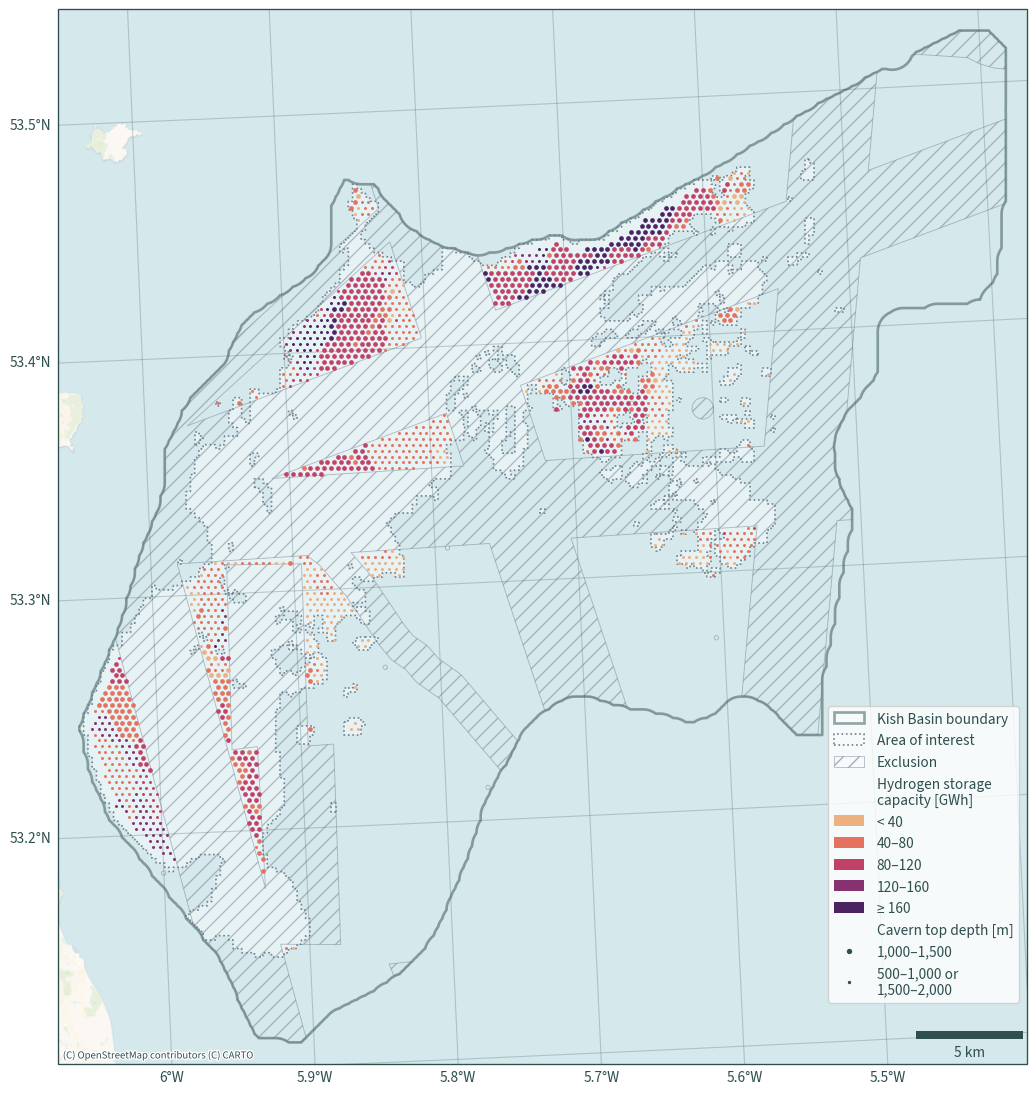

In [23]:
plot_map_alt(ds, caverns, zones, [40 * n for n in range(5)])

## Restrict cavern height to 155 m, depth to 1,000-1,500 m

In [24]:
# height = 155 m, 1,000 m <= depth <= 1,500 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds,
    constraints={"height": 155, "min_depth": 1000, "max_depth": 1500},
)

In [25]:
caverns, _ = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

------------------------------------------------------------
Without constraints, excluding salt formation edges...
Number of potential caverns: 901
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 406
Caverns excluded: 54.94%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 359
Caverns excluded: 60.16%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 357
Caverns excluded: 60.38%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 357
Caverns excluded: 60.38%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 357
Caverns excluded: 60.38%
------------------------------------------------------------


In [26]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[155],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [27]:
# calculate volumes and capacities
caverns = cap.calculate_capacity_dataframe(cavern_df=caverns)

In [28]:
# proportion of working gas to total gas
caverns["working_mass_pct"] = caverns["working_mass"] / (
    caverns["working_mass"] + caverns["mass_operating_min"]
)

In [80]:
caverns.drop(
    [
        "x",
        "y",
        "TopTWT",
        "BaseDepth",
        "TopDepth",
        "BaseDepthSeabed",
        "height",
        "cavern_height",
    ],
    axis=1,
).describe()

,Thickness,TopDepthSeabed,cavern_depth,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,mass_operating_min,mass_operating_max,capacity,working_mass_pct
count,357.000000,357.000000,357.000000,357.000000,357.000000,3.570000e+02,3.570000e+02,357.000000,357.000000,3.570000e+02,3.570000e+02,3.570000e+02,357.000000,357.000000
mean,348.449451,1150.733769,1230.733769,326452.980096,332.208766,8.451593e+06,2.253758e+07,5.880170,14.549611,2.830165e+06,1.919599e+06,4.749764e+06,94.307377,0.596122
std,79.484430,141.546802,141.546802,0.000000,5.308005,9.997734e+05,2.666062e+06,0.573075,1.310212,2.406478e+05,1.870821e+05,4.277225e+05,8.018921,0.002992
min,245.000700,920.558475,1000.558475,326452.980096,323.577193,6.825819e+06,1.820218e+07,4.925143,12.346650,2.422773e+06,1.607828e+06,4.030601e+06,80.732188,0.590582
25%,289.482900,1023.648373,1103.648373,326452.980096,327.443064,7.553963e+06,2.014390e+07,5.366576,13.376497,2.614863e+06,1.751935e+06,4.366797e+06,87.133031,0.593628
50%,334.550700,1145.320306,1225.320306,326452.980096,332.005761,8.413356e+06,2.243562e+07,5.870203,14.536705,2.829205e+06,1.916345e+06,4.745551e+06,94.275414,0.596181
75%,386.933500,1267.560593,1347.560593,326452.980096,336.589772,9.276764e+06,2.473804e+07,6.358160,15.646159,3.032095e+06,2.075640e+06,5.107735e+06,101.036147,0.598806
max,754.985800,1419.035241,1499.035241,326452.980096,342.270072,1.034666e+07,2.759109e+07,6.939123,16.948768,3.267678e+06,2.265297e+06,5.532976e+06,108.886301,0.601095


In [29]:
# totals
caverns[
    [
        "cavern_volume",
        "working_mass",
        "capacity",
        "mass_operating_min",
        "mass_operating_max",
    ]
].sum()

cavern_volume         1.165437e+08
working_mass          1.010369e+09
capacity              3.366773e+04
mass_operating_min    6.852969e+08
mass_operating_max    1.695666e+09
dtype: float64

In [30]:
# compare to Ireland's electricity demand in 2050 (Deane, 2021)
print(
    "Energy capacity as a percentage of Ireland's electricity demand in 2050:",
    f"{(caverns['capacity'].sum() / 1000 / 122 * 100):.2f}–" +
    f"{(caverns['capacity'].sum() / 1000 / 84 * 100):.2f}%"
)

Energy capacity as a percentage of Ireland's electricity demand in 2050: 27.60–40.08%


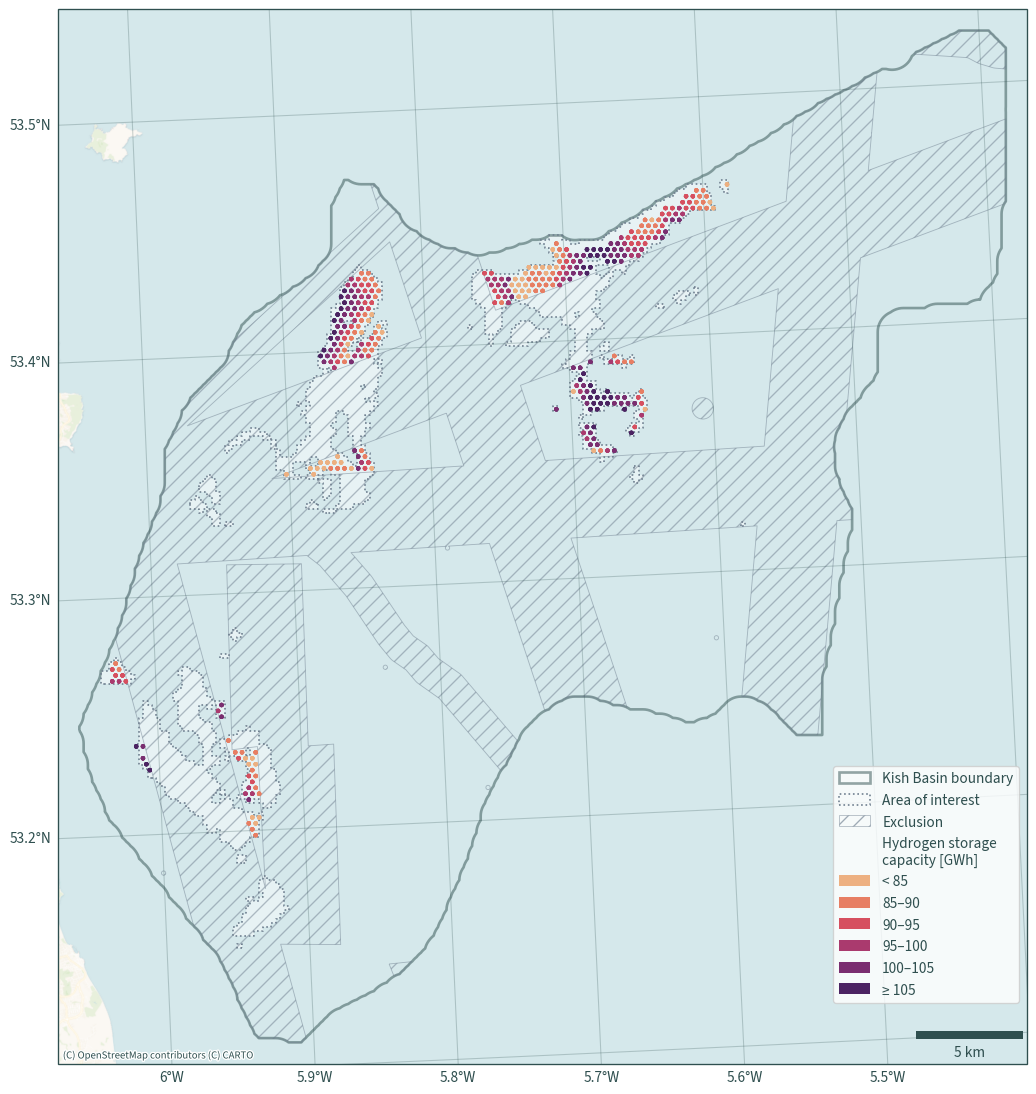

In [31]:
plot_map_alt(ds, caverns, zones, [80 + n * 5 for n in range(6)], False)

## Distribution

In [32]:
def cavern_boxplot(cavern_df):
    """Helper function for creating boxplots"""
    fig1, axes1 = plt.subplots(1, 4, figsize=(11, 4.5))
    sns.boxplot(
        cavern_df,
        y="cavern_depth",
        color=sns.color_palette("rocket", 1)[0],
        width=0.2,
        ax=axes1[0],
        legend=False,
        linecolor="black",
        linewidth=1.1,
        gap=0.1,
        flierprops={"markeredgecolor": "grey", "alpha": 0.5},
    )
    axes1[0].set_ylabel("Top depth [m]")
    axes1[0].get_yaxis().set_major_formatter(
        ticker.FuncFormatter(lambda x, p: format(int(x), ","))
    )
    sns.boxplot(
        (cavern_df[["p_operating_min", "p_operating_max"]] / 1e6)
        .rename(
            columns={
                "p_operating_min": "min",
                "p_operating_max": "max",
            }
        )
        .melt(),
        y="value",
        hue="variable",
        palette="rocket_r",
        width=0.4,
        ax=axes1[1],
        linecolor="black",
        linewidth=1.1,
        gap=0.1,
        flierprops={"markeredgecolor": "grey", "alpha": 0.5},
    )
    axes1[1].set_ylabel("Operating pressure [MPa]")
    axes1[1].legend()
    sns.boxplot(
        (cavern_df[["mass_operating_min", "working_mass"]] / 1e6)
        .rename(
            columns={
                "mass_operating_min": "cushion",
                "working_mass": "working",
            }
        )
        .melt(),
        y="value",
        hue="variable",
        palette="rocket_r",
        width=0.4,
        ax=axes1[2],
        linecolor="black",
        linewidth=1.1,
        gap=0.1,
        flierprops={"markeredgecolor": "grey", "alpha": 0.5},
    )
    axes1[2].set_ylabel("Gas mass [kt]")
    axes1[2].legend()
    sns.boxplot(
        cavern_df,
        y="capacity",
        color=sns.color_palette("rocket", 1)[0],
        width=0.2,
        ax=axes1[3],
        legend=False,
        linecolor="black",
        linewidth=1.1,
        gap=0.1,
        flierprops={"markeredgecolor": "grey", "alpha": 0.5},
    )
    axes1[3].set_ylabel("Energy storage capacity [GWh]")
    sns.despine(bottom=True)
    plt.tight_layout()
    plt.show()

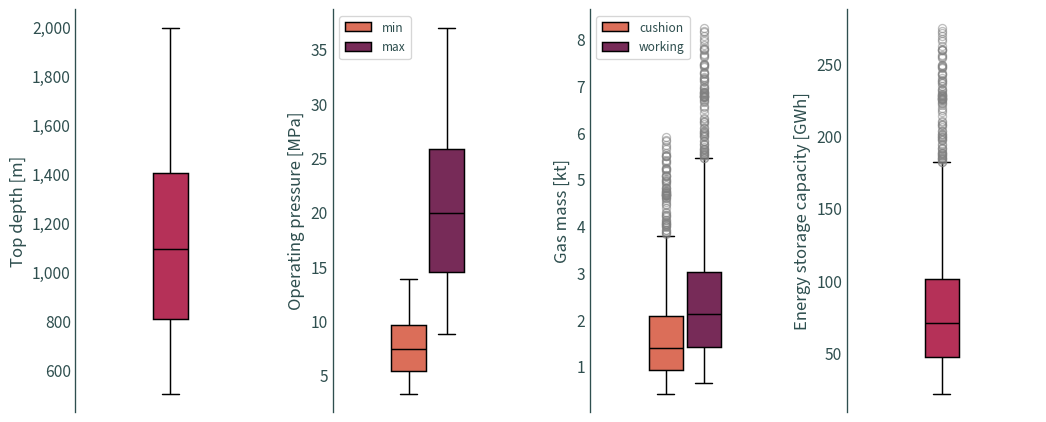

In [30]:
cavern_boxplot(caverns_pot_all)

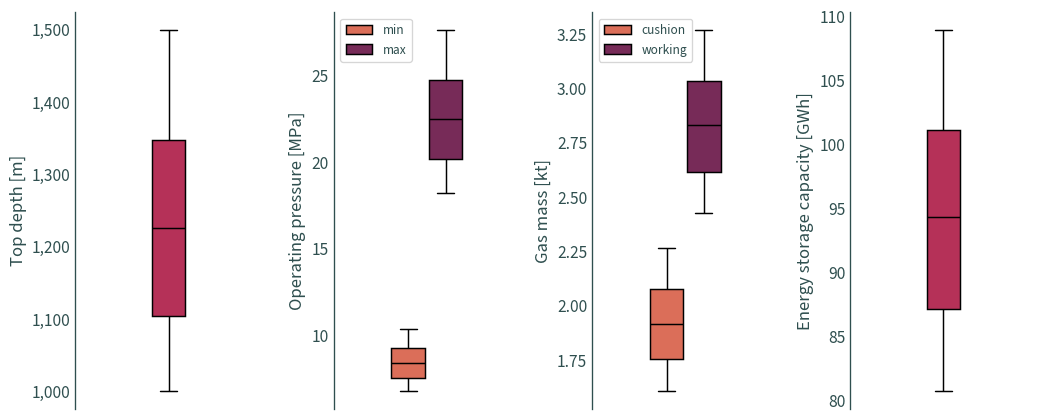

In [31]:
cavern_boxplot(caverns)

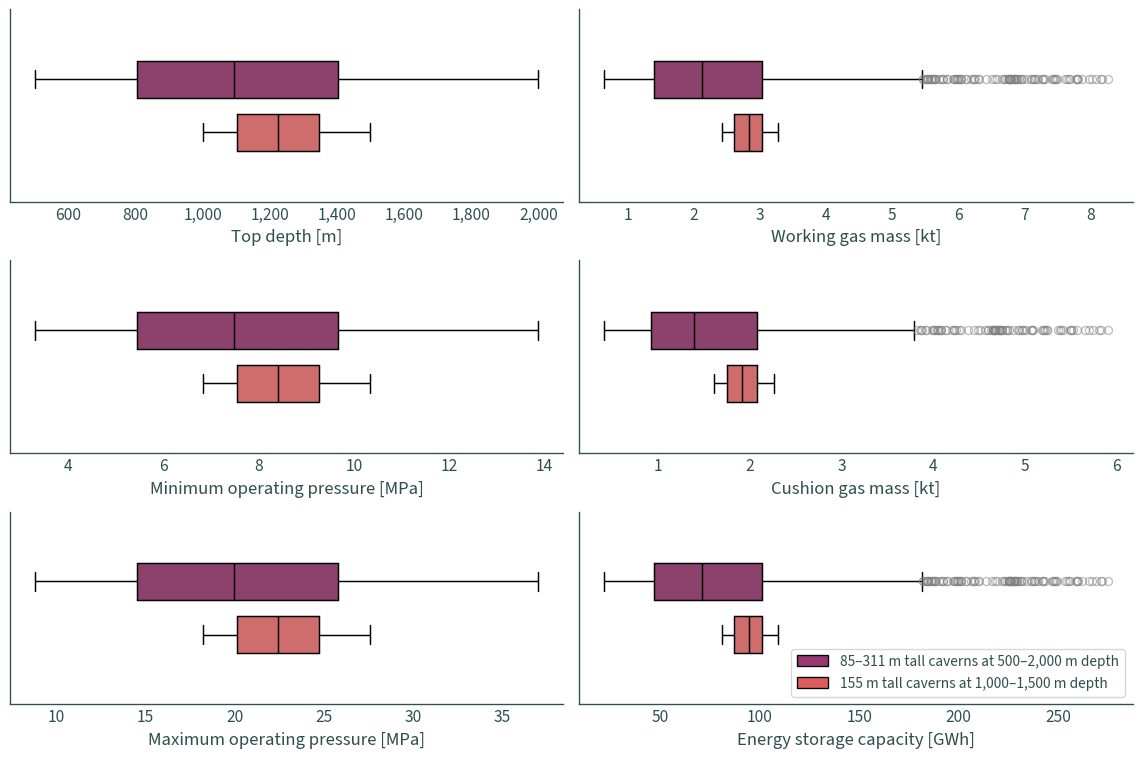

In [36]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
for variable, label, axis in zip(
    [
        "cavern_depth",
        "working_mass",
        "p_operating_min",
        "mass_operating_min",
        "p_operating_max",
        "capacity",
    ],
    [
        "Top depth [m]",
        "Working gas mass [kt]",
        "Minimum operating pressure [MPa]",
        "Cushion gas mass [kt]",
        "Maximum operating pressure [MPa]",
        "Energy storage capacity [GWh]",
    ],
    axes.flat,
):
    if variable in ["cavern_depth", "capacity"]:
        d1 = caverns_pot_all[[variable]]
        d2 = caverns[[variable]]
    else:
        d1 = caverns_pot_all[[variable]] / 1e6
        d2 = caverns[[variable]] / 1e6
    sns.boxplot(
        pd.concat(
            [d1.set_axis(["all"], axis=1), d2.set_axis(["optimal"], axis=1)]
        )
        .melt()
        .dropna(),
        x="value",
        hue="variable",
        palette="flare_r",
        linecolor="black",
        linewidth=1.1,
        gap=0.3,
        width=0.55,
        flierprops={"markeredgecolor": "grey", "alpha": 0.5},
        ax=axis,
        legend=False,
    )
    axis.set_xlabel(label)
    if variable == "cavern_depth":
        axis.get_xaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, p: format(int(x), ","))
        )

legend_handles = [
    mpatches.Patch(
        facecolor=sns.color_palette("flare_r", 2)[0],
        label="85–311 m tall caverns at 500–2,000 m depth",
        edgecolor="black",
    ),
    mpatches.Patch(
        facecolor=sns.color_palette("flare_r", 2)[1],
        label="155 m tall caverns at 1,000–1,500 m depth",
        edgecolor="black",
    ),
]
plt.legend(
    loc="lower right",
    handles=legend_handles,
    fontsize=11.5
)
sns.despine()
plt.tight_layout()
plt.show()